### Kallus et al., 2018の人工データでのOff Policy Evaluationの実験

behavior policyがXと相関する場合

### (注意事項) optimal bandwidthについて
* デフォルトのhをoptimalじゃなくても適当にバンド幅を決めて実験してみる。
* optimal bandwidthが間違っているのか、OPEの計算が間違っているのかがわかる。


* linspaceでいくつかhを取って結果を確かめたところ, h=0.23くらいでベストな値が出ていることがわかったのでoptimalbandiwidthを求める実装以外は間違えていない。

```python
for n0_optimal_bandwidth in np.linspace(0.23, 0.27, 10):
    pass
...
fig.savefig(f'h0.23_0.27/{n0_optimal_bandwidth:.4f}.png')
```


* ひとまずh=0.23をoptimalということにする。

In [1]:
import pickle
import os

from matplotlib import pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

from optimal_bandwidth import get_optimal_h
from datasets import gen
from policies import behavior_policy1
from utils import epanechnikov_kernel, clipping_ips, _estimate_value_on_n

In [5]:
# \pi(x) = \beta * x
def target_policy(x):
    beta = 1
    return beta * x

In [9]:
def trial(estimate_method, b_policy, t_policy, record=True, output_fname=''):
    if record:
        assert output_fname != '', 'give me output filename(output_fname)'

    estimand_transaction_over_sample_size = []
    for n in tqdm(range(10, 310, 10), leave=False):
        ope_estimands = _estimate_value_on_n(estimate_method, b_policy, t_policy, n)
        estimand_transaction_over_sample_size.append([ope_estimands.mean(), ope_estimands.std()])
        
    if record:
        os.makedirs('results/ope_synthe/', exist_ok=True)
        with open(f'results/ope_synthe/{output_fname}.pickle', 'wb') as f:
            pickle.dump(estimand_transaction_over_sample_size, f)
    return np.array(estimand_transaction_over_sample_size)

In [8]:
def true_outcomes(n, X, Y, T, Q, piX):
    np.random.seed(10)
    return 2 * np.power(X - piX, 3/2) + 0.2 * np.random.randn(n).reshape(-1, 1)

trial(true_outcomes, behavior_policy1, target_policy, record=True, output_fname='true_outcomes');

  0%|          | 0/30 [00:00<?, ?it/s]

In [43]:
def continuous_ips(n, X, Y, T, Q, piX, n0_optimal_bandwidth=0.23):
    # COPE
    h = n0_optimal_bandwidth * np.power(10/n, 1/5)

    # clipping propensity score
    Q_clipped = clipping_ips(Q, clip_param=0.1)

    estimated_value = np.mean(epanechnikov_kernel((piX - T) / h) * Y / Q_clipped) / h
    return estimated_value

# continuous ope
trial(continuous_ips, record=True, output_fname='continuous_ips');

  0%|          | 0/30 [00:00<?, ?it/s]

In [44]:
# FIXME: 実数なのでIndicatorが一致する点がほとんど存在しない
def discretized_ips(n, X, Y, T, Q, piX):
    clipped_Q = clipping_ips(Q, clip_param=0.1)
    
    bins = np.linspace(T.min(), T.max(), 11)
    discretized_T = np.argmin(np.abs(T - bins), axis=1)
    discretized_piX = np.argmin(np.abs(piX - bins), axis=1)
    rej_mask = (discretized_piX == discretized_T)  # sample REJection MASK
    estimated_value = np.mean(Y[rej_mask] / clipped_Q[rej_mask])
    return estimated_value

trial(discretized_ips, record=True, output_fname='discretized_ips');

  0%|          | 0/30 [00:00<?, ?it/s]

/home/kato/anaconda3/envs/ope_with_conT/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kato/anaconda3/envs/ope_with_conT/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
def direct_method_poly(n, X, Y, T, Q, piX):
    '''
    多項式回帰モデルを用いたDirect Method
    '''
    pre = PolynomialFeatures(degree=3)
    reg = LinearRegression()
    behavior_features = pre.fit_transform(np.hstack([X, T]))
    reg.fit(behavior_features, Y[:, 0])
    
    evaluation_features = pre.fit_transform(np.hstack([X, piX]))
    estimated_reward = reg.predict(evaluation_features)
    return np.mean(estimated_reward)

trial(direct_method_poly, record=True, output_fname='DM_poly');

  0%|          | 0/30 [00:00<?, ?it/s]

In [49]:
def direct_method_rf(n, X, Y, T, Q, piX):
    '''
    Random Forestを用いたDirect Method
    '''
    reg = RandomForestRegressor(n_estimators=10)
    behavior_features = np.hstack([X, T])
    reg.fit(behavior_features, Y[:, 0])
    evaluation_features = np.hstack([X, piX])
    estimated_reward = reg.predict(evaluation_features)
    return estimated_reward

trial(direct_method_rf, record=True, output_fname='DM_RF');

  0%|          | 0/30 [00:00<?, ?it/s]

### 他の手法との比較結果を可視化

In [47]:
settings = [
    ('true_outcomes', 'b', '+'),
    ('continuous_ips', 'r', 'v'),
    ('discretized_ips', 'g', 'o'),
    ('DM_poly', 'm', '*'),
    ('DM_RF', 'crimson', 'o')
]

def see_results(show_std=False, show_oracle=False):
    estimand_over_sample_sizes = []
    for fname, _, _ in settings:
        with open(f'results/ope_synthe/{fname}.pickle', 'rb') as f:
            estimands = pickle.load(f)
        estimand_over_sample_sizes.append(np.array(estimands))

    sample_sizes = range(10, 310, 10)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot()
    ax.set_xlim(0, 300)
    ax.set_ylim(-0.05, 0.2)
    for i, estimands in enumerate(estimand_over_sample_sizes):
        fname, color, marker = settings[i]
        mean = estimands[:, 0]
        std_err = estimands[:, 1]
        ax.scatter(sample_sizes, mean, color=color, label=fname, marker=marker)
        ax.plot(sample_sizes, mean, color=color)
        if show_std:
            ax.fill_between(sample_sizes, mean - std_err, mean + std_err, alpha=0.2, color=color)
    if show_oracle:
        plt.hlines(xmin=0, xmax=300, y=0, colors='b', linestyles='dashed', label='oracle value')
    plt.legend(loc='best', ncol=2)
    plt.show()

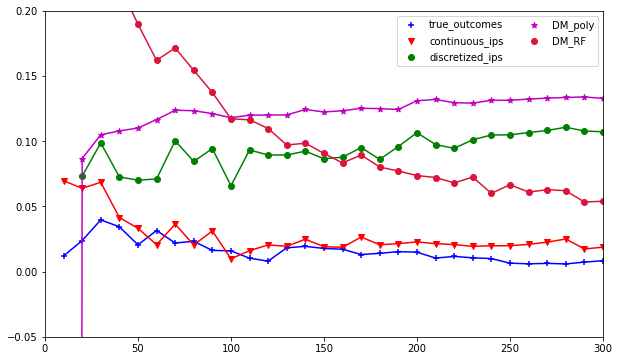

In [50]:
see_results()

### 問題
* discretized methodが動かない
    * 解釈違う？
* optimal bandwidth計算できない
    * 現在はh = 0.23で代用
    * 近似方法を改善するだけでは？
* DM polyのグラフが論文のものと異なる
* 標準偏差を表示したらバラバラ過ぎた。↓

### コメント
* DMは学習時も予測時も同じXで良いの？分割するならしきい値は？
* 標準偏差はこんなもんなのでは？論文の値がばらつき少なすぎないか？

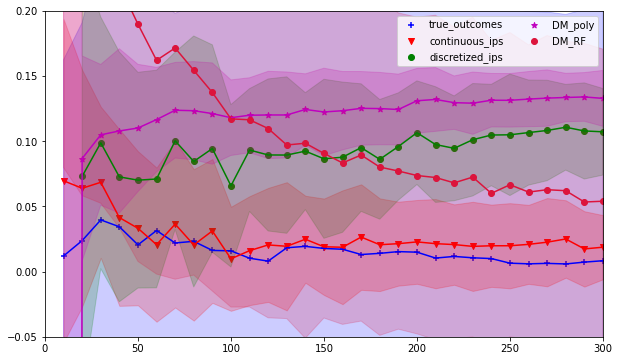

In [51]:
see_results(show_std=True)